# SimMod 1. Audio + Video features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/10/19 | 18:00-22:00 | Watching lectures 1 and 2 |
| 2023/10/26 | 17:00-22:00 | Watching lectures 3 - 5 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/04 | 21:00-00:00 | Setting up the repository and environment |
| 2023/12/09 | 10:00-22:00 | SimMod 1 First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | SimMod 1 First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | SimMod 1 Optical flow + features on top of optical flow |
| 2024/01/04 | 11:00-20:00 | SimMod 1 Features on top of optical flow, audio features |
| 2024/01/12 | 17:00-22:00 | SimMod 1 Hand In Notebooks |
| 2024/01/14 | 21:30-23:00 | SimMod 1 Hand In Notebooks |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/26 | 09:00-12:00 | Watching lectures 1 and 2|
| 2023/10/27 | 19:00-21:00 | Watching lecture 3|
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/12/09 | 10:00-22:00 | SimMod 1 First audio and video features for Kermit and Statler & Waldorf |
| 2023/12/09 | 10:30-20:00 | SimMod 1 First experiments, feature refinement, training classifiers, creating clean intermediate hand in file |
| 2024/01/03 | 11:00-22:00 | SimMod 1 Train-test split, cross-validation, audio features, plots |
| 2024/01/04 | 11:00-20:00 | SimMod 1 Features on top of optical flow, audio features, plots |
| 2024/01/12 | 17:00-22:00 | SimMod 1 Hand In Notebooks |
| 2024/01/14 | 21:30-23:00 | SimMod 1 Hand In Notebooks |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

## 4. Feature extraction
We extract all audio features using librosa library. We use frames of length 0.4s to extract features, so for each frame, we consider the audio before and after. To ensure that no data leakage happens by audio being present in both train and test splits, we cut the episodes only between the scene change (for more info, see 3. Train Test Splitting).

### 4.1 Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import re
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import io, train, eval
from utils import feature_engineering as fe

In [2]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

We don't describe and extract audio and video features, since they stay the same as described in the respective notebooks. Here we only load the precomputed features. The features can be extracted from scratch in the respective notebooks.

Here we provide a short overview of the used features. Detailed description of the features can be found in the respective notebooks.

**Video Features**:
- Dense Optical Flow
  - Estimates foreground masks based on a dynamic threshold. 
  - Mean std-deviation and flow-magnitude of the image frame.
- Kermit color pixels (from full picture, as well as foreground and background using optical flow masks)
- Dominant hues (from full picture, as well as foreground and background using optical flow masks)
- Hough Transform for straight lines (failed approach, not included)
- Blob detection with OpenCV and skimage highlighting important colors (failed approach, not included)

**Audio Features**:
- Zero-crossing rate
- RMS
- 5 frequencies with biggest magnitudes based on FFT (both frequencies and magnitudes used as features)

## 5. Classification

### 5.1 Load features

The (pre-)computed features are loaded from the ```data/features``` directory.

In [3]:
final_df = gt_df.copy()

In [4]:
zcr_feat_dict = pickle.load(open("../data/features/zcr_features.pkl", "rb"))

for ep in episode_names:
    final_df.loc[final_df['episode'] == ep, 'zcr'] = zcr_feat_dict[ep]

In [5]:
rms_feat_dict = pickle.load(open("../data/features/rms_features.pkl", "rb"))

for ep in episode_names:
    final_df.loc[final_df['episode'] == ep, 'rms'] = rms_feat_dict[ep]

In [6]:
biggest_freqs_feat_dict = pickle.load(open(f"../data/features/biggest_freqs_features.pkl", "rb"))

for ep in episode_names:
    current_ep_feats = biggest_freqs_feat_dict[ep]
    for feat_name, feat in current_ep_feats.items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

In [7]:
flow_feat_dict = pickle.load(open("../data/features/flow_features.pkl", "rb"))

for ep in episode_names:
    current_ep_feats = flow_feat_dict[ep]
    for feat_name, feats in current_ep_feats.items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feats[1:]

In [8]:
kermit_pixels = pickle.load(open("../data/features/kermit_pixels.pkl", "rb"))

for ep in episode_names:
    for feat in kermit_pixels[ep].keys():
        final_df.loc[final_df['episode'] == ep, feat] = kermit_pixels[ep][feat]

In [9]:
for hue_feat_type in ['full', 'background', 'foreground']:
    hue_feat_list = pickle.load(open(f"../data/features/hue_feat_list_{hue_feat_type}.pkl", "rb"))

    for ep in episode_names:
        current_hue_feat_list = hue_feat_list[ep]['hue_list']
        for i, col_name in enumerate([f'percentage_{hue_feat_type}', f'hue_{hue_feat_type}']):
            for k in range(current_hue_feat_list.shape[1]):
                final_df.loc[final_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

### 5.2 Run experiments
On our machines, the training takes approx. 1 hour in total. If you want to retrain a classifier and generate new evaluation data, set ```train_models``` param to ```True``` (make sure that ```save_results``` is also set to ```True```, so that evaluation data is saved). Important! Each classification target (Kermit/Statler&Waldorf) has it's own parameters, if you want to retrain both, change parameters in both places.

For our experiments, we decided to use:
- RandomForest (ensemble, separator)
- DecisionTree (separator) 
- KNN (hedger) 

classifiers to cover wide range of different types of classifiers.  

#### 5.2.1 Kermit

In [10]:
train_models = False
save_results = True
feat_type = 'combined'
target_col = 'Kermit'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c
              or 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- zcr
- rms
- freq_0
- biggest_mag_0
- freq_1
- biggest_mag_1
- freq_2
- biggest_mag_2
- freq_3
- biggest_mag_3
- freq_4
- biggest_mag_4
- mean_flow
- std_dev_flow
- num_kermit_pixels_foreground
- num_kermit_pixels_background
- num_kermit_pixels
- kermit_pixels_ratio
- percentage_full_0
- percentage_full_1
- percentage_full_2
- percentage_full_3
- percentage_full_4
- hue_full_0
- hue_full_1
- hue_full_2
- hue_full_3
- hue_full_4
- percentage_background_0
- percentage_background_1
- percentage_background_2
- percentage_background_3
- percentage_background_4
- hue_background_0
- hue_background_1
- hue_background_2
- hue_background_3
- hue_background_4
- percentage_foreground_0
- percentage_foreground_1
- percentage_foreground_2
- percentage_foreground_3
- percentage_foreground_4
- hue_foreground_0
- hue_foreground_1
- hue_foreground_2
- hue_foreground_3
- hue_foreground_4


In [11]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [50, 100]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [50, 100]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

In [12]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

#### 5.2.2 Statler & Waldorf

In [13]:
train_models = False
save_results = True
feat_type = 'combined'
target_col = 'StatlerWaldorf'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c
              or 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training: \n- {train_cols_str}")

Columns used for training: 
- zcr
- rms
- freq_0
- biggest_mag_0
- freq_1
- biggest_mag_1
- freq_2
- biggest_mag_2
- freq_3
- biggest_mag_3
- freq_4
- biggest_mag_4
- mean_flow
- std_dev_flow
- num_kermit_pixels_foreground
- num_kermit_pixels_background
- num_kermit_pixels
- kermit_pixels_ratio
- percentage_full_0
- percentage_full_1
- percentage_full_2
- percentage_full_3
- percentage_full_4
- hue_full_0
- hue_full_1
- hue_full_2
- hue_full_3
- hue_full_4
- percentage_background_0
- percentage_background_1
- percentage_background_2
- percentage_background_3
- percentage_background_4
- hue_background_0
- hue_background_1
- hue_background_2
- hue_background_3
- hue_background_4
- percentage_foreground_0
- percentage_foreground_1
- percentage_foreground_2
- percentage_foreground_3
- percentage_foreground_4
- hue_foreground_0
- hue_foreground_1
- hue_foreground_2
- hue_foreground_3
- hue_foreground_4


In [14]:
clf_config = [
    {
        'model_name': 'RandomForest',	
        'model': RandomForestClassifier(),
        'param_grid': {
            'clf__n_estimators': [10, 50],
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'clf__max_depth': [10, 50]
        },
    },
    {
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'clf__n_neighbors': [1, 3, 10]
        },
    }
]

In [15]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv(final_df, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type)

## 6. Results & Discussion

#### 6.1 Kermit

In [29]:
target_col = 'Kermit'

# combined approach
feat_type = 'combined'
combined_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
combined_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
combined_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
combined_precision_dict, combined_recall_dict, combined_f1_dict, combined_fpr_dict, combined_tpr_dict = eval.get_eval_info(combined_eval_df, combined_clf_dict_outer)

# video approach
feat_type = 'video'
video_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
video_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
video_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
video_precision_dict, video_recall_dict, video_f1_dict, video_fpr_dict, video_tpr_dict = eval.get_eval_info(video_eval_df, video_clf_dict_outer)

# audio approach
feat_type = 'audio'
audio_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
audio_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
audio_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
audio_precision_dict, audio_recall_dict, audio_f1_dict, audio_fpr_dict, audio_tpr_dict = eval.get_eval_info(audio_eval_df, audio_clf_dict_outer)

The following curves provide infomation about precision, recall, TPR and FPR for all experiment runs, both from inner and outer CV loops.

As we can see from the following curves, the classifier which uses a combination of video and audio features performs very well, but one cannot say that it performs that much better than the classifier built on video features alone. The reason behind it is probably that as was discussed in the ```SIM1_Hand_In_Audio.ipynb``` notebook, the audio features from SimMod1 are not complex enough to capture the differences in the voices and are not very helpful for classification.

We can also see that RandomForest clearly outperforms other classifiers, probably because it's the most complex model out of three.

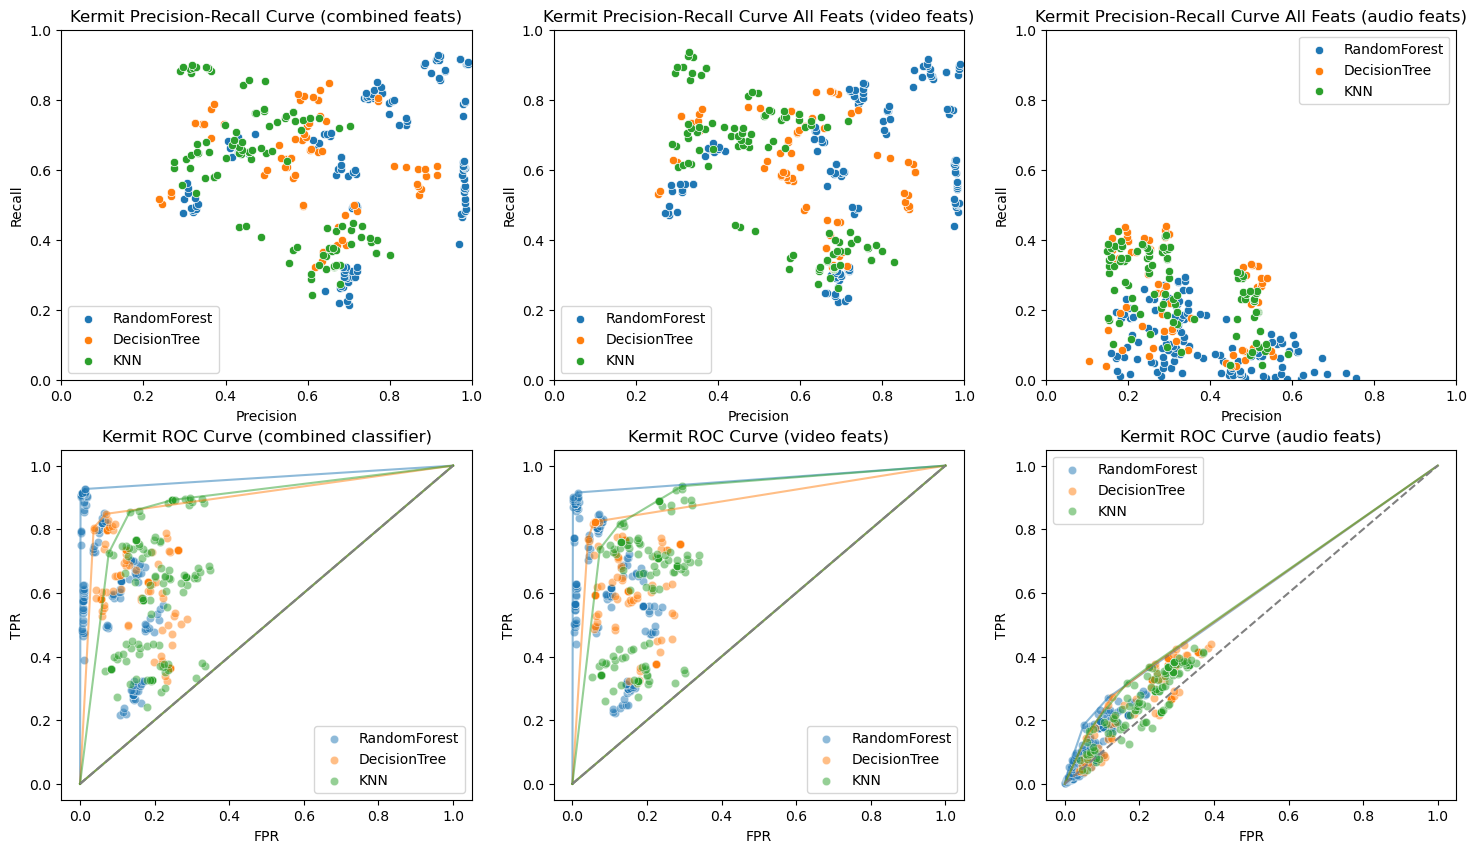

In [17]:
_, axes = plt.subplots(2, 3, figsize=(18, 10))
eval.plot_precision_recall_curve(combined_precision_dict, combined_recall_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (combined feats)', ax=axes[0][0], plot_curve=False)
eval.plot_roc_curve(combined_fpr_dict, combined_tpr_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (combined classifier)', ax=axes[1][0])

eval.plot_precision_recall_curve(video_precision_dict, video_recall_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats (video feats)', ax=axes[0][1], plot_curve=False)
eval.plot_roc_curve(video_fpr_dict, video_tpr_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (video feats)', ax=axes[1][1])

eval.plot_precision_recall_curve(audio_precision_dict, audio_recall_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats (audio feats)', ax=axes[0][2], plot_curve=False)
eval.plot_roc_curve(audio_fpr_dict, audio_tpr_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (audio feats)', ax=axes[1][2])

The following curves provide the information about TPR and FPR at different classification thresholds for the best hyperparameter combinations of each model. It supports the previous statements: both combined and video classifiers performance is comparable, performance of audio classifier is not very good, RandomForest outperforms other models in all cases.

The performance strongly depends on the train-test split. The biggest difference for combined and video classifiers is seen in the Fold 5. Discussion on the topic is available in the ```SIM1_Hand_In_Video.ipynb``` 

**Combined classifier**

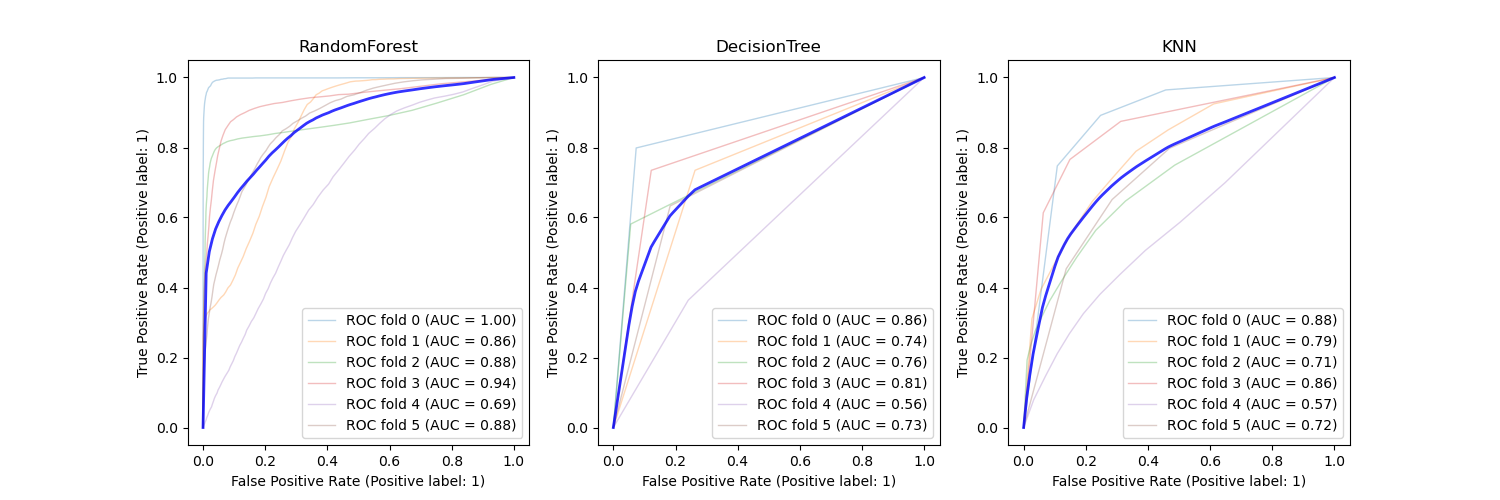

In [18]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_combined_precision_recall.png"
display(Image(filename=filename))

**Video classifier**

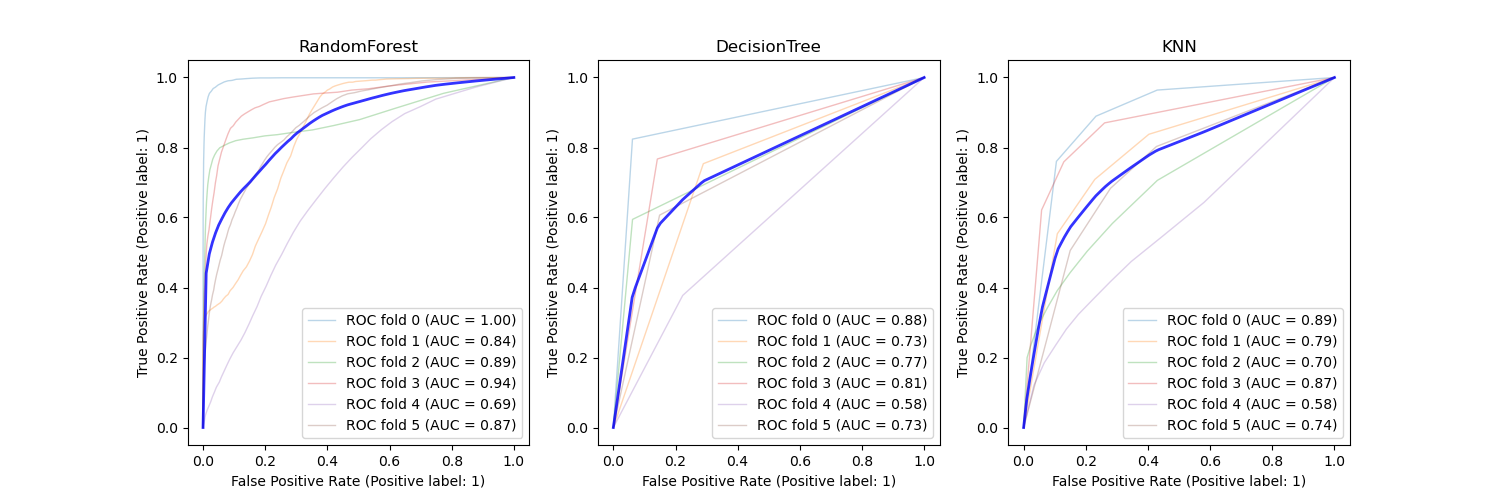

In [19]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

**Audio classifier**

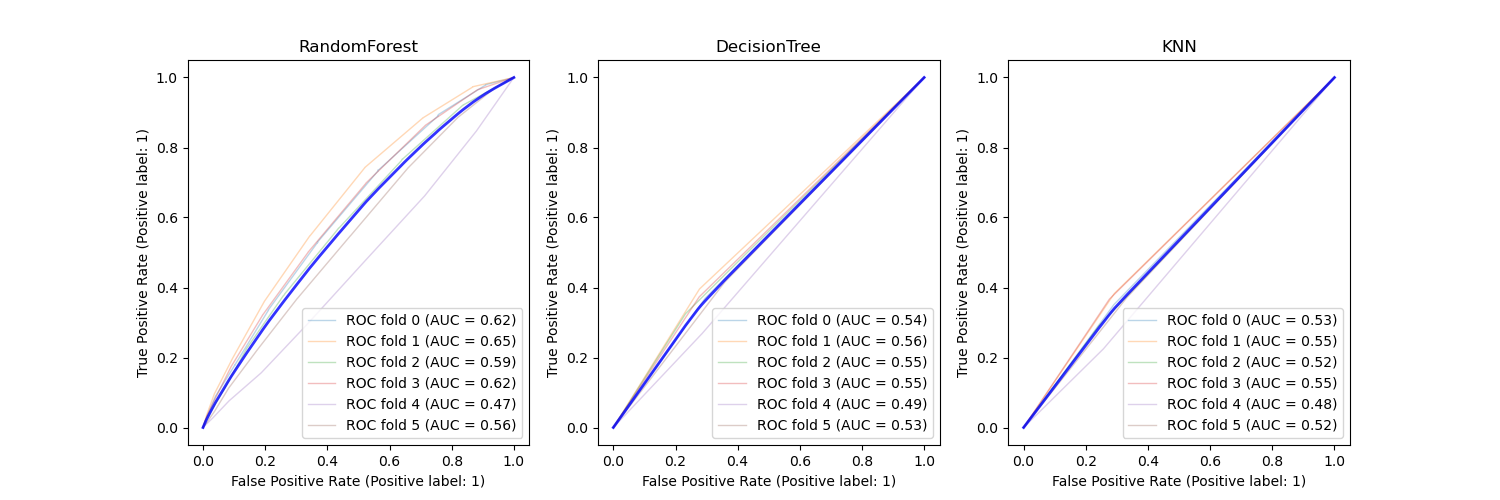

In [20]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_audio_precision_recall.png"
display(Image(filename=filename))

As we can see, the combined classifier mostly relies on the video features. The feature importances of the combined classifier are very similar to the ones of the video classifier.

The most important video features are the number of kermit pixels is by far the most important feature. It is followed by the dominant hues from the whole picture, which also relies on colors.

(0.0, 0.19)

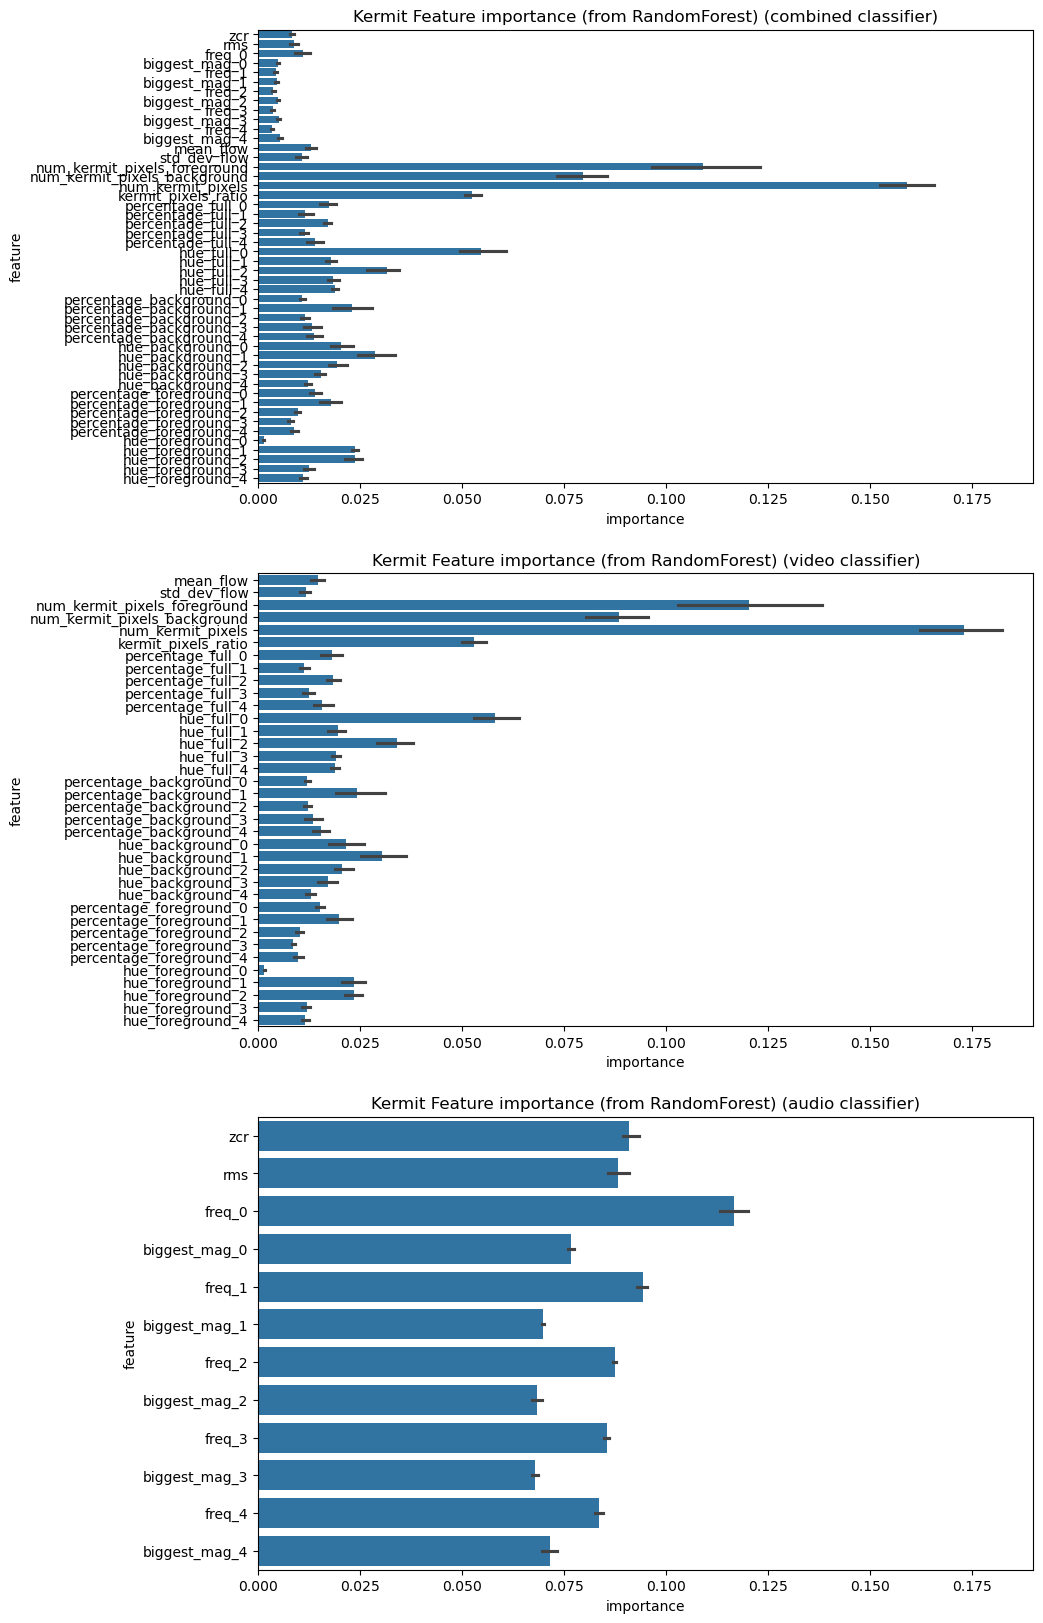

In [30]:
combined_train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c
              or 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
video_train_cols = [c for c in final_df.columns
              if 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
audio_train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c]
combined_feature_importance_df = eval.get_feature_importance_rf(combined_train_cols, combined_clf_dict_outer)
video_feature_importance_df = eval.get_feature_importance_rf(video_train_cols, video_clf_dict_outer)
audio_feature_importance_df = eval.get_feature_importance_rf(audio_train_cols, audio_clf_dict_outer)

_, axes = plt.subplots(3, 1, figsize=(10, 20))
sns.barplot(data=combined_feature_importance_df, y='feature', x='importance', ax=axes[0])
axes[0].set(title=f'{target_col} Feature importance (from RandomForest) (combined classifier)')
axes[0].set_xlim(0, 0.19)

sns.barplot(data=video_feature_importance_df, y='feature', x='importance', ax=axes[1])
axes[1].set(title=f'{target_col} Feature importance (from RandomForest) (video classifier)')
axes[1].set_xlim(0, 0.19)

sns.barplot(data=audio_feature_importance_df, y='feature', x='importance', ax=axes[2])
axes[2].set(title=f'{target_col} Feature importance (from RandomForest) (audio classifier)')
axes[2].set_xlim(0, 0.19)

#### 6.2 Statler & Waldorf

In [22]:
target_col = 'StatlerWaldorf'

# combined approach
feat_type = 'combined'
combined_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
combined_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
combined_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
combined_precision_dict, combined_recall_dict, combined_f1_dict, combined_fpr_dict, combined_tpr_dict = eval.get_eval_info(combined_eval_df, combined_clf_dict_outer)

# video approach
feat_type = 'video'
video_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
video_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
video_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
video_precision_dict, video_recall_dict, video_f1_dict, video_fpr_dict, video_tpr_dict = eval.get_eval_info(video_eval_df, video_clf_dict_outer)

# audio approach
feat_type = 'audio'
target_col = 'Audio_StatlerWaldorf'
audio_eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
audio_clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
audio_tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))
audio_precision_dict, audio_recall_dict, audio_f1_dict, audio_fpr_dict, audio_tpr_dict = eval.get_eval_info(audio_eval_df, audio_clf_dict_outer)

In comparison to the Kermit classifier, there is much less variability in the ROC curve results across the folds and classifiers. All of them perform well, RandomForest somewhat better than KNN and DecisionTree. This can probably be explained by the fact that Statler&Waldorf look almost the same independently from the episode or scene.

Again, there is little difference between combined and video classifier, indicating that the classifier mostly relies on video features.

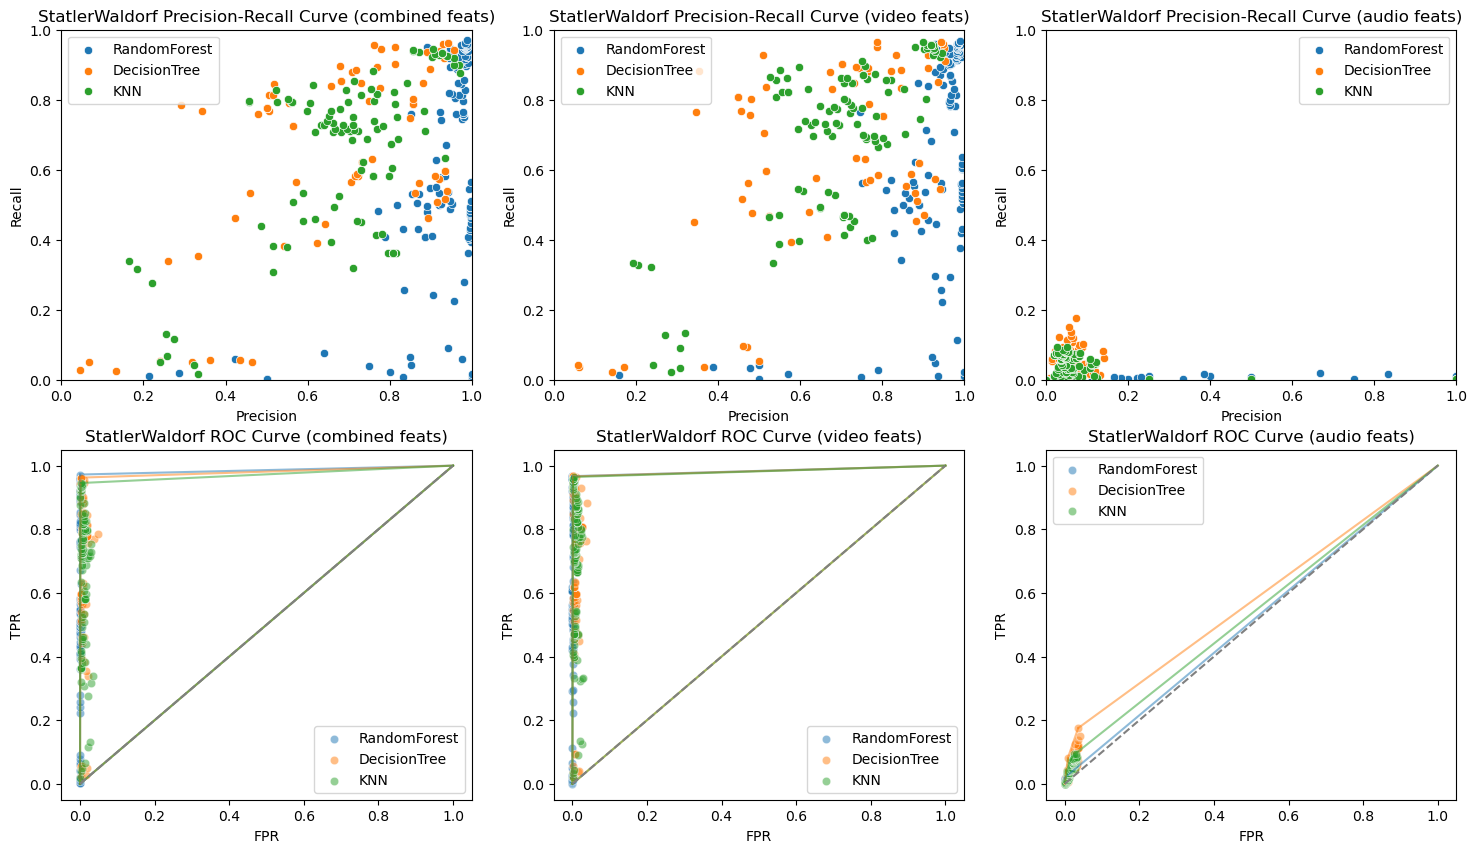

In [23]:
target_col = 'StatlerWaldorf'
_, axes = plt.subplots(2, 3, figsize=(18, 10))
eval.plot_precision_recall_curve(combined_precision_dict, combined_recall_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (combined feats)', ax=axes[0][0], plot_curve=False)
eval.plot_roc_curve(combined_fpr_dict, combined_tpr_dict, model_names=combined_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (combined feats)', ax=axes[1][0])

eval.plot_precision_recall_curve(video_precision_dict, video_recall_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (video feats)', ax=axes[0][1], plot_curve=False)
eval.plot_roc_curve(video_fpr_dict, video_tpr_dict, model_names=video_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (video feats)', ax=axes[1][1])

eval.plot_precision_recall_curve(audio_precision_dict, audio_recall_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve (audio feats)', ax=axes[0][2], plot_curve=False)
eval.plot_roc_curve(audio_fpr_dict, audio_tpr_dict, model_names=audio_clf_dict_outer.keys(), title=f'{target_col} ROC Curve (audio feats)', ax=axes[1][2])

**Combined classifier**

Again, we can see that RandomForest performs much better than other classifiers independently from train-test split. The prediction of RandomForest is almost perfect in all the cases for combined and video classifiers.

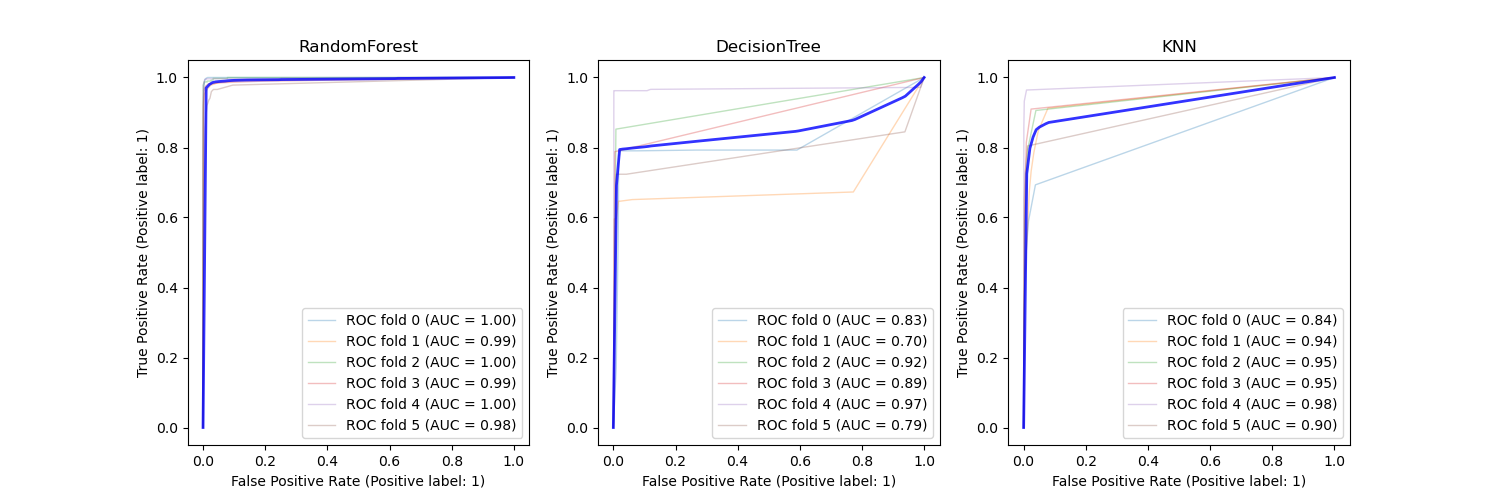

In [24]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_combined_precision_recall.png"
display(Image(filename=filename))

**Video classifier**

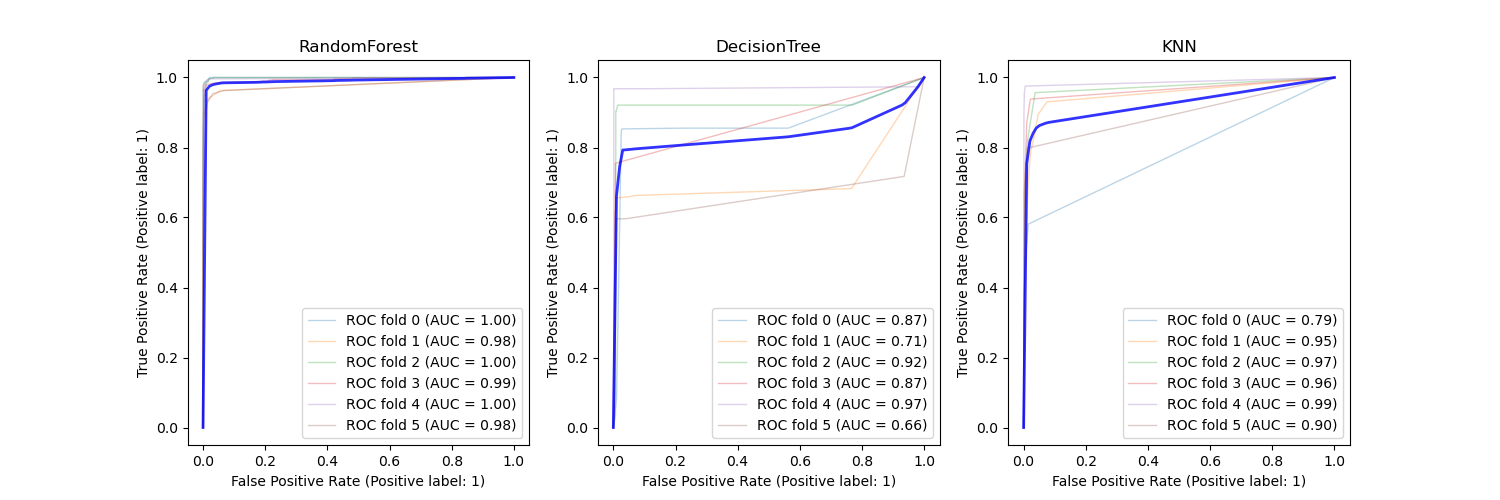

In [25]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_video_precision_recall.png"
display(Image(filename=filename))

**Audio classifier**

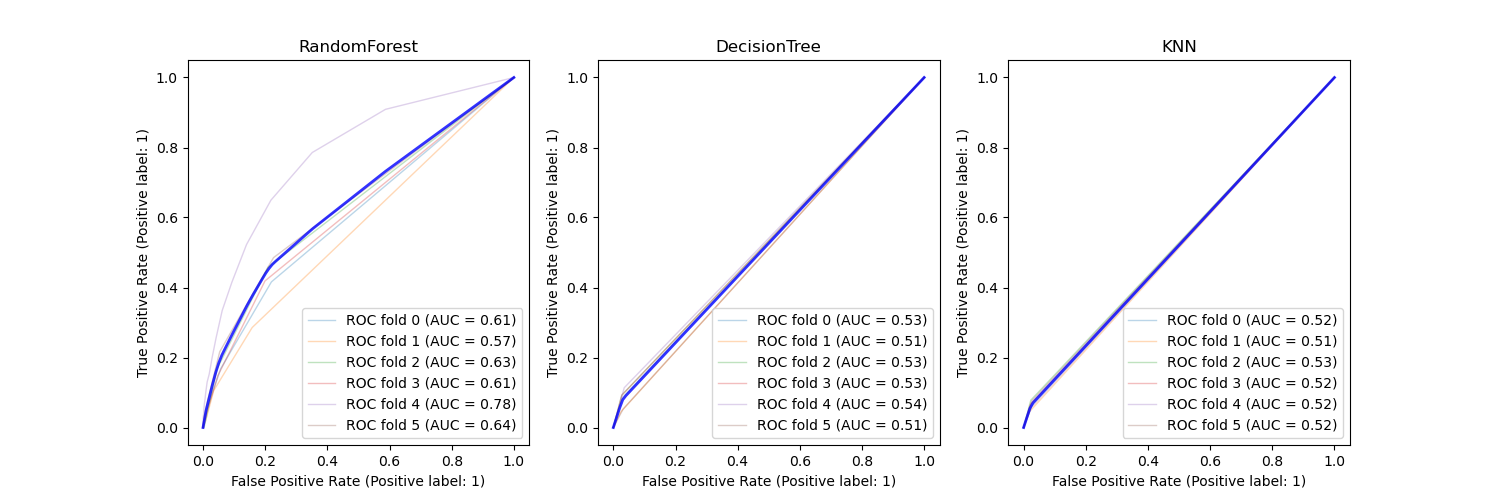

In [26]:
from IPython.display import Image, display
filename = f"../data/eval/DT_Audio_{target_col}_audio_precision_recall.png"
display(Image(filename=filename))

Again, there is little difference in feature importances between combined and video classifier, supporting the hypothesis that classifier mostly relies on video features.

We can see also see more variability in the important features in comparison to Kermit. The background hues and full picture hues are more important than in classification for Kermit, indicating that the classifier learns to detect the balcony and not the characters directly. Based on our data, it is still fine, since the gentlemen are almost always on the balcony.

Also mean flow became more important, probably because the characters don't move much in the scene.

Foreground Kermit pixels are still important, probably because the absence of Kermit is a good indicator that the gentlemen are present, since they rarely appear together (at least, based on our dataset). This may lead to problems when trying to classify based on other episodes.

(0.0, 0.17)

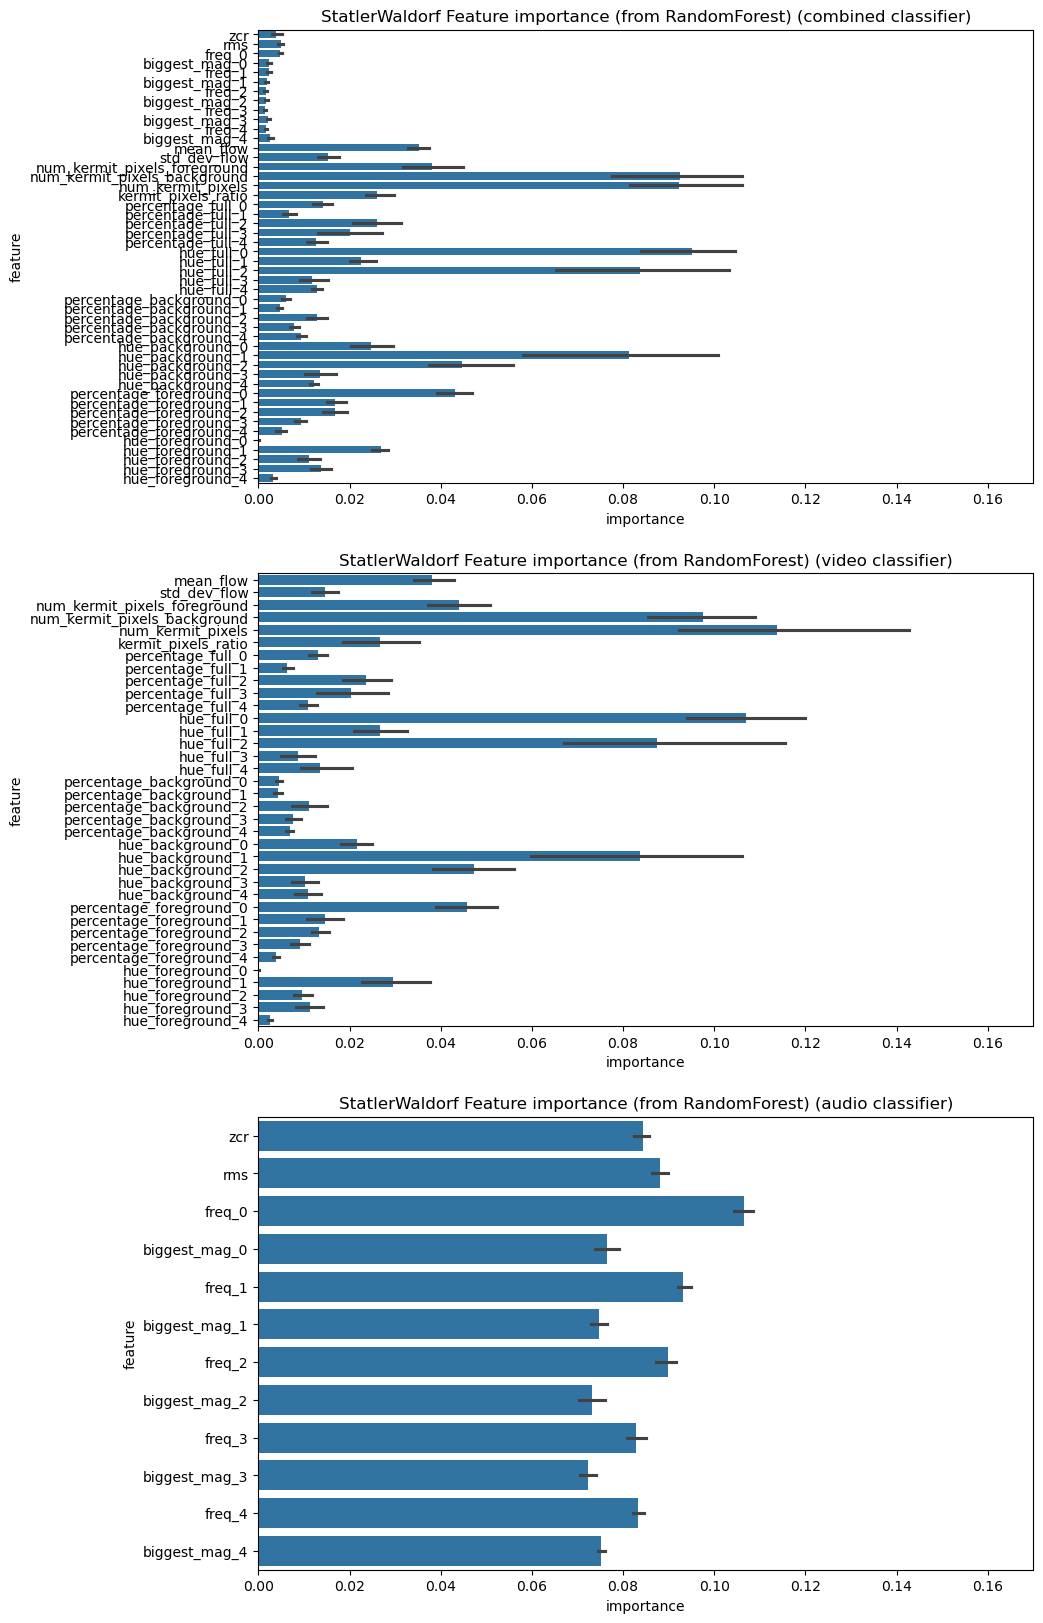

In [28]:
combined_train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c
              or 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
video_train_cols = [c for c in final_df.columns
              if 'flow' in c
              or 'kermit_' in c
              or 'percentage' in c
              or 'hue' in c]
audio_train_cols = [c for c in final_df.columns 
              if 'rms' in c
              or 'zcr' in c
              or 'freq' in c
              or 'biggest_mag' in c]
combined_feature_importance_df = eval.get_feature_importance_rf(combined_train_cols, combined_clf_dict_outer)
video_feature_importance_df = eval.get_feature_importance_rf(video_train_cols, video_clf_dict_outer)
audio_feature_importance_df = eval.get_feature_importance_rf(audio_train_cols, audio_clf_dict_outer)

_, axes = plt.subplots(3, 1, figsize=(10, 20))
sns.barplot(data=combined_feature_importance_df, y='feature', x='importance', ax=axes[0])
axes[0].set(title=f'{target_col} Feature importance (from RandomForest) (combined classifier)')
axes[0].set_xlim(0, 0.17)

sns.barplot(data=video_feature_importance_df, y='feature', x='importance', ax=axes[1])
axes[1].set(title=f'{target_col} Feature importance (from RandomForest) (video classifier)')
axes[1].set_xlim(0, 0.17)

sns.barplot(data=audio_feature_importance_df, y='feature', x='importance', ax=axes[2])
axes[2].set(title=f'{target_col} Feature importance (from RandomForest) (audio classifier)')
axes[2].set_xlim(0, 0.17)